In [1]:
import os
os.chdir(os.getcwd()[:os.getcwd().rfind('\\')])

In [2]:
import numpy as np
from src.utils.preprocessing_utils import load_image, preprocess_image, get_bounding_boxes, get_corners, get_areas, filter_by_area, get_boxes_sides_length, filter_by_sides
from src.utils.frontend_utils import input_for_frontend
from src.utils.data_utils import zero_padding, remove_extra_space_around_characters, get_characters
import cv2
from skimage import io
import os
from tensorflow import keras
import numpy as np
from skimage.transform import resize
from skimage import io, color
from sklearn.preprocessing import LabelEncoder
import statistics
from src.utils.preprocessing_utils import filter_boxes_by_models_predictions, get_all_leters, project_y_letters, find_distances_between_coordinates, get_lines, get_sorted_lines, get_text_lines
from src.utils.frontend_utils import get_model_response
from tqdm import tqdm

## Load Model

In [3]:
GEO_ALPHABET = {'ა': 1, 'ბ': 2, 'გ': 3, 'დ': 4, 'ე': 5, 'ვ': 6, 
                'ზ': 7, 'თ': 8, 'ი': 9, 'კ': 10, 'ლ': 11, 'მ': 12, 
                'ნ': 13, 'ო': 14, 'პ': 15, 'ჟ': 16, 'რ': 17, 'ს': 18, 
                'ტ': 19, 'უ': 20, 'ფ': 21, 'ქ': 22, 'ღ': 23, 'ყ': 24, 
                'შ': 25, 'ჩ': 26, 'ც': 27, 'ძ': 28, 'წ': 29, 'ჭ': 30, 
                'ხ': 31, 'ჯ': 32, 'ჰ': 33} 

model_name = 'models/first_cnn/first_cnn.h5'
label_encoder_name = 'models/first_cnn/first_cnn_label_encoder.npy'

model = keras.models.load_model(model_name)
le = LabelEncoder()
le.classes_ = np.load(label_encoder_name, allow_pickle=True)
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))

## Preprocess Image

In [4]:
image_file = 'data/raw/0002.jpg'

img = load_image(image_file)
binary_image = preprocess_image(img)
# characteristics
bounding_boxes = get_bounding_boxes(binary_image)
corners = get_corners(bounding_boxes)
areas = get_areas(corners)
widths, heights = get_boxes_sides_length(corners)

# filters
filtered_areas, filtered_corners, area_mask = filter_by_area(areas, corners, filter_value = 0)
filtered_widths, filtered_heights = np.array(widths)[np.array(area_mask)].tolist(), np.array(heights)[np.array(area_mask)].tolist()

filtered_corners, side_mask = filter_by_sides(filtered_corners, filtered_widths, filtered_heights)
filtered_widths, filtered_heights = np.array(filtered_widths)[np.array(side_mask)].tolist(), np.array(filtered_heights)[np.array(side_mask)].tolist()
filtered_areas = np.array(filtered_areas)[np.array(side_mask)].tolist()

filtered_areas, filtered_corners, area_mask = filter_by_area(filtered_areas, filtered_corners, filter_value = np.mean(filtered_areas)/2)
filtered_widths, filtered_heights = np.array(filtered_widths)[np.array(area_mask)].tolist(), np.array(filtered_heights)[np.array(area_mask)].tolist()

In [5]:
# %%timeit
characters = get_characters(binary_image, filtered_corners)

## Predictions

In [6]:
predictions = []
for c in characters:
    preprocessed = zero_padding(remove_extra_space_around_characters(c, extra_space_value=0))
    image_cnn = np.zeros(shape=(1, 28, 28))
    image_cnn[0] = zero_padding(remove_extra_space_around_characters(c, extra_space_value=0))
    prediction = model.predict(image_cnn, verbose=False)
    letter, confidence = np.argmax(prediction), np.max(prediction)
    # save top 3 predictions as well
    top_preds = [le_name_mapping[p] for p in (-prediction).argsort()[0]][:3]
    top_confs = np.sort(prediction[0])[::-1][:3] 
    
    predictions.append((le_name_mapping[letter], confidence, (top_preds, top_confs)))

In [7]:
model_response = get_model_response(predictions, filtered_corners)

### Get only confident boxes

In [8]:
f_corners, f_predictions, prediction_mask = filter_boxes_by_models_predictions(filtered_corners, predictions, 0.9)

In [9]:
f_t_corners, f_t_predictions, prediction_t_mask = filter_boxes_by_models_predictions(filtered_corners, predictions, 0.3)
model_response_t = get_model_response(f_t_predictions, f_t_corners)

In [10]:
all_letters = get_all_leters(f_corners)
y_letters = project_y_letters(all_letters)
coord_distances = find_distances_between_coordinates(y_letters)
lines = get_lines(coord_distances, all_letters, y_letters)
sorted_lines = get_sorted_lines(lines)
text_lines = get_text_lines(sorted_lines, model_response_t)

In [11]:
sorted_text_lines = [sorted(tl, key=lambda x: x['corners'][0][0]) for tl in text_lines]

In [12]:
mean_spaces_between_chars = [statistics.mean([abs(stl[i]['corners'][2][0] - stl[i+1]['corners'][0][0]) for i in range(len(stl)-1)]) for stl in sorted_text_lines]
sentences_word_list = []
result_text = ""
for i in range(len(sorted_text_lines)):
    sentence = sorted_text_lines[i]
    mean_space = mean_spaces_between_chars[i]
    sent = []
    word = []
    for i in range(len(sentence)-1):
        word.append(sentence[i])
        if abs(sentence[i]['corners'][2][0] - sentence[i+1]['corners'][0][0]) > mean_space:
            sent.append(word)
            word = []
    word.append(sentence[-1])
    if word:
        sent.append(word)
    sentences_word_list.append(sent)

## RoBERTa Tokenizer & Vocab

In [13]:
from typing import List, Any, Dict, Optional, Text
import pickle
from transformers import PreTrainedTokenizerFast


ROBERTA_TOKENS_MAP_PATH = 'models/roberta_tokenizer/special_tokens_map.json'
ROBERTA_CONFIG_PATH = 'models/roberta_tokenizer/tokenizer_config.json'
ROBERTA_TOKENS_MAP_PATH = 'models/roberta_tokenizer/tokenizer.json'
TOKENIZER_PATH = 'models/roberta_tokenizer'
VOCAB_PATH = 'models/vocab/light_vocab.pkl'

class CandidatesSelector():

    def __init__(self, tokenizer_path=TOKENIZER_PATH, vocab_path=VOCAB_PATH) -> None:
        self.tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
        self.MAX_LEN = 28

        with open(vocab_path, 'rb') as handle:
            self.vocab = pickle.load(handle)

    def choose_best_candidate(self, words: List[str])-> str:
            minx = 10000
            candidates = []
            for w in words:
                enc = self.tokenizer(text=w)
                n_tokens = len(enc['input_ids'])
                if n_tokens <= minx:
                    minx = n_tokens
                    candidates.append(w)                    
            
            if len(candidates) == 0:
                return ''
            
            if len(candidates) == 1:
                return candidates[0]
            # vocab logic
            cand_vocab_counts = [(w, self.vocab.get(w, 0)) for w in candidates]
            best_cand = max(cand_vocab_counts, key = lambda x: x[1])[0]
            return best_cand


    def select_candidate(self,  candidates: List[str]) -> str:        
        best_candidate = self.choose_best_candidate(candidates)
        return best_candidate

In [14]:
candicates_selector = CandidatesSelector()

In [15]:
from typing import List, Dict, Any, Tuple

def get_word_variants(word: List[Dict[str, Any]], min_thresh=0.97) -> Tuple[List[str], List[float]]:
    word_vars = [""]
    probs = [1.0]
    for char_var in word:
        letters = char_var['top_letters']
        confs = char_var['top_confidences']
        char_vars = []
        char_probs = []
        for l, c in zip(letters, confs):
            char_vars += [v+l for v in word_vars]
            char_probs += [p*c for p in probs]
            if c > min_thresh:
                break
        word_vars = char_vars
        probs = char_probs
    return word_vars, probs


## Generate Text

In [16]:
text_lines = []
for line in tqdm(sentences_word_list):
    sentence = []
    for word in tqdm(line):
        w, p = get_word_variants(word)   
#         top_words = [w[i] for i in (-np.array(p)).argsort()[:int(np.sqrt(len(w)))]]        
        best_word = candicates_selector.select_candidate(w)
        sentence.append(best_word)
    text_lines.append(sentence)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 166.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1000.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 131.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 136.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 399.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 60.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 54.51it/s]

100%|███████████████████████████

In [20]:
result_text = "\n".join([" ".join(l) for l in text_lines])

In [21]:
print(result_text)

ბ ნ ნ შესავალი
ნ ჭკ ჭყ კძცაუქუნის ა ნახევარი უაღრესად ნ ყოფიერი პერიოდი
ქართლ ს ისტორი ში ეს არის დიდ დ გ ნ თლუბული ს ხელმწიფო
მოღვაწის ქართველი მეფის ვახტანგ სა ის მმართველობის და მე
ფობლც ნანა რომელ ც შვუყნიც დ მოუქიდებლოჭ ბოცა და პოლიტიქუ
რი ერთიანობის თვის ბრძოლითა დე დიდი ქულტურლლ სუგანმგწათ
ლებლრ შვრებით ხასიუდება მაჰმადიანთა ძალმომრეობის პირო
ბუბში ვახწაწგი ეროვნულ ქრიცტიანული პოლიწიქიც მედროშედ მ
მოვიდა მ ნ კარგად უწყოდა რომ ეროვნული სახის შენარჩუნება
ფიზიქლრი არსებობის თვის ბრძოლის გარდა ქვეყნის იცტორიუჟ ლ
კულტურულ ფი მუმქვიდრეობიც მოვლ ცა დე მის შემდგომ გამდიდრუ
ბ ც ც მოითხოვდა ცწორედ ამ მ რივაა საყურ დღებო ვახტანგის
როგორც ქულტურული მრღვ წის დე განმანათლებლის მუცნიურიცა
დ მთარგმნულიც მოღვაწეობ
ე ჯწანგი რის უშუ ლო წარმმართველი დე აქტიური მონაწილე
იმ საერთო ეროვნულ ქლლტურული პროცესიც რომულცაც ქართულ
ანმანულუ ბლშბჯს უწოდე ბ ე ნ ცწორედ გაჯოტჯი ზენა იყო უს დნა
სეთი დაუღალავი მედგარი მუშაობა რომელსაც ერთი საზოგ დო
მიმ რთულუბა ჰქონდ დ ფართო ღრმ ნიად გი უპყრ უფლებაც გვა
შლემს შ რთულ

In [18]:
from matplotlib import pyplot as plt

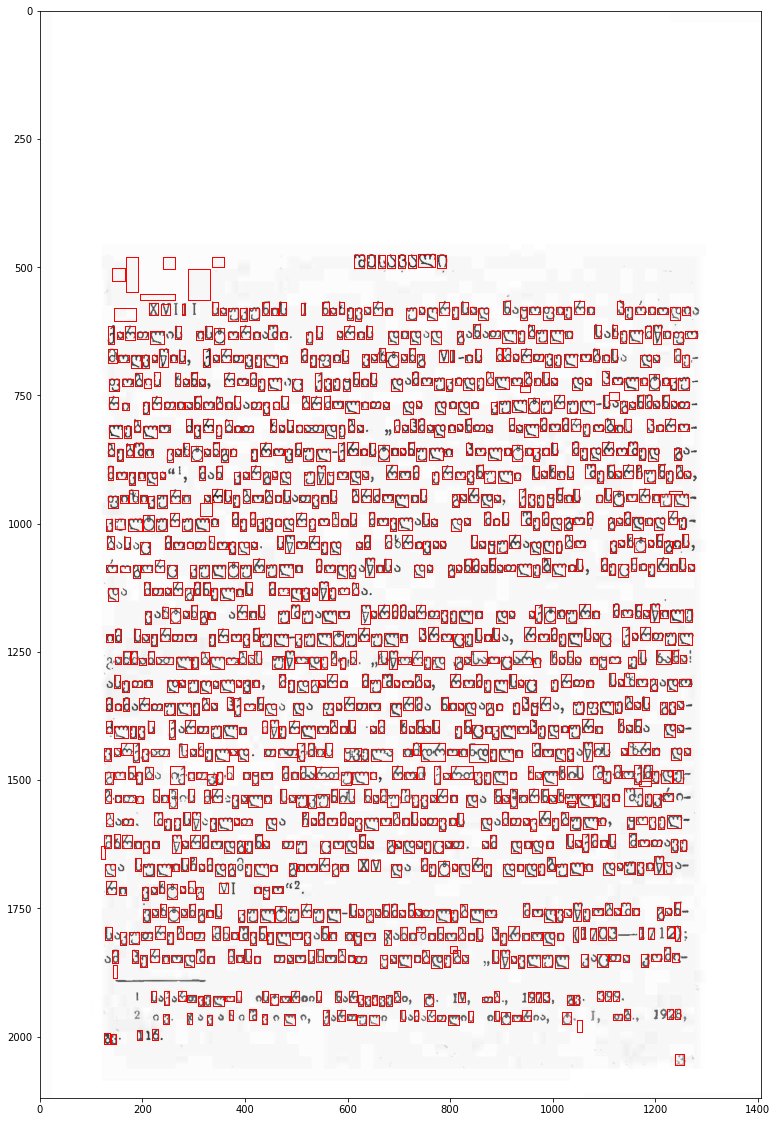

<Figure size 432x288 with 0 Axes>

In [19]:
experiment_boxes = [m['corners'] for m in model_response_t]
plt.figure(figsize=(30, 20))                            
i = 0
for bx in experiment_boxes:
    width = abs(bx[1][0] - bx[0][0])
    height = abs(bx[3][1] - bx[0][1])
    if width*height == 0:
        print('zero')
    else:
        plt.plot([bx[0][0],bx[1][0]],[bx[0][1],bx[1][1]],'r-',linewidth=1)
        plt.plot([bx[1][0],bx[2][0]],[bx[1][1],bx[2][1]],'r-',linewidth=1)
        plt.plot([bx[2][0],bx[3][0]],[bx[2][1],bx[3][1]],'r-',linewidth=1)
        plt.plot([bx[3][0],bx[0][0]],[bx[3][1],bx[0][1]],'r-',linewidth=1)
        # plt.show()
#     if i == 6:
#         break
    i+=1
plt.imshow(img,'gray')
plt.show()
plt.clf()